In [1]:
%run code/undistort
import matplotlib.pyplot as plt

objpoints, imgpoints = prepare_obj_img_points()

In [2]:
%matplotlib qt
img = cv2.imread('test_images/test1.jpg')
undistorted = cal_undistort(img, objpoints, imgpoints)
plt.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))

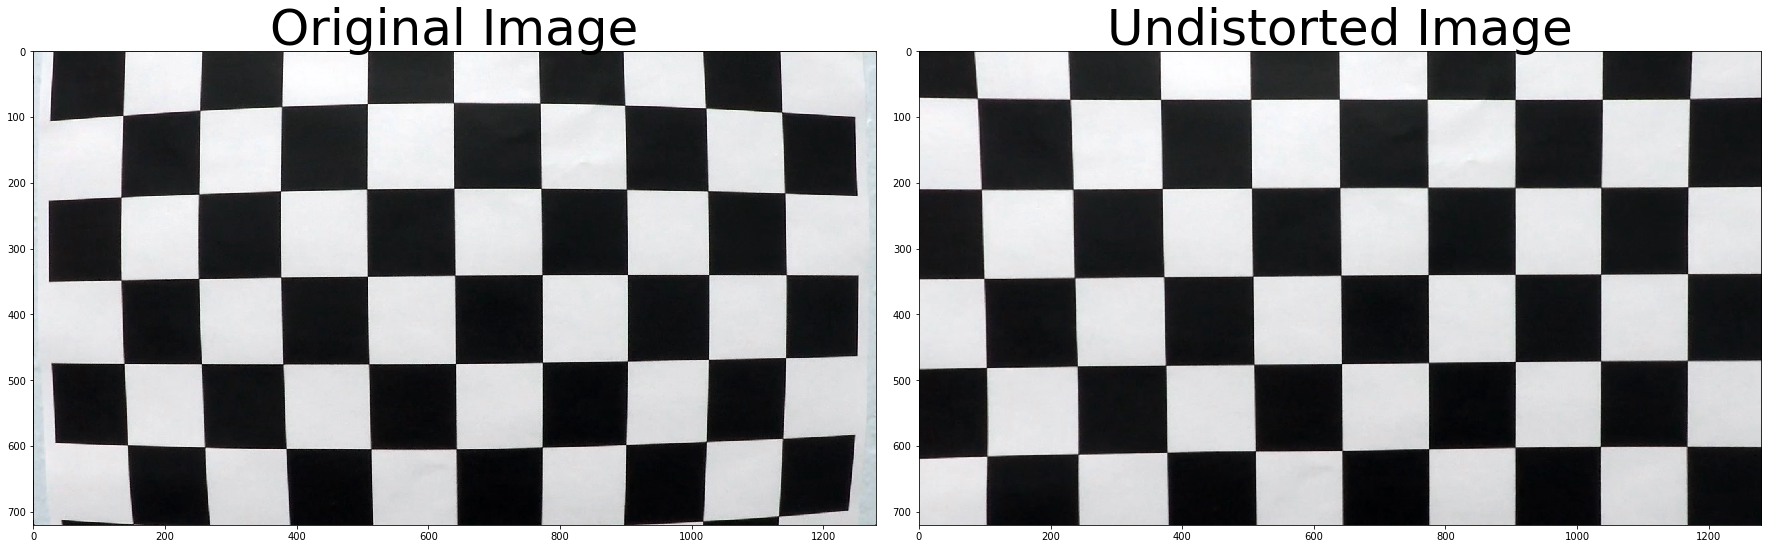

In [4]:
img = cv2.imread('camera_cal/calibration1.jpg')

undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [3]:
%run code/color_and_gradient_threshed
img = cv2.imread('test_images/test1.jpg')
undistorted = cal_undistort(img, objpoints, imgpoints)
binary_img = threshed_binary_pipeline(undistorted, s_thresh=(100, 255), sx_thresh=(30, 100))
plt.imshow(binary_img, cmap='gray')

In [4]:
%run code/perspective_transform

img = cv2.imread('test_images/test1.jpg')
undistorted = cal_undistort(img, objpoints, imgpoints)
img_size = (undistorted.shape[1], undistorted.shape[0])
src = np.float32(
    [[(img_size[0] / 2) - 45, img_size[1] / 2 + 100],
    [((img_size[0] / 6)), img_size[1]],
    [(img_size[0] * 5 / 6) + 130, img_size[1]],
    [(img_size[0] / 2 + 95), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
print(src, dst)
transformed = warper(undistorted, src, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(with_points_drawn(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB), src))
ax1.set_title('Undistorted image with src points draw', fontsize=30)
ax2.imshow(with_points_drawn(cv2.cvtColor(transformed, cv2.COLOR_BGR2RGB), dst))
ax2.set_title('Warped result with dst points drawn', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

[[ 595.       460.     ]
 [ 213.33333  720.     ]
 [1196.6666   720.     ]
 [ 735.       460.     ]] [[320.   0.]
 [320. 720.]
 [960. 720.]
 [960.   0.]]


In [6]:
%run code/perspective_transform

img = cv2.imread('test_images/test3.jpg')
undistorted = cal_undistort(img, objpoints, imgpoints)
binary_img = threshed_binary_pipeline(undistorted, s_thresh=(100, 255), sx_thresh=(30, 100))
img_size = (undistorted.shape[1], undistorted.shape[0])
src = np.float32(
    [[(img_size[0] / 2) - 45, img_size[1] / 2 + 100],
    [((img_size[0] / 6)), img_size[1]],
    [(img_size[0] * 5 / 6) + 130, img_size[1]],
    [(img_size[0] / 2 + 95), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

binary_warped = warper(binary_img, src, dst)

plt.imshow(binary_warped, cmap='gray')

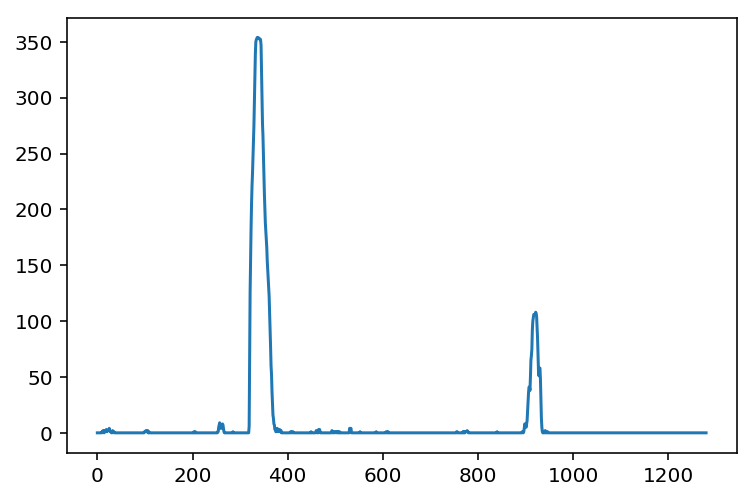

In [77]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

# Create histogram of image binary activations
histogram = hist(binary_warped)

# Visualize the resulting histogram
plt.plot(histogram)

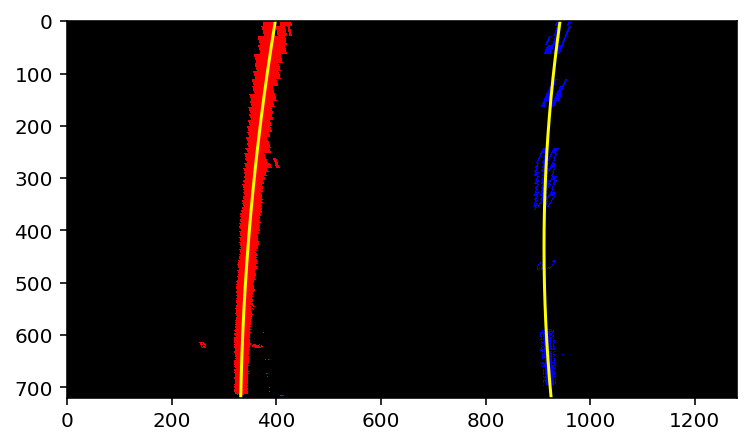

In [136]:
%run code/lane_pixel_finder
%run code/fit_polynomial

leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
left_fitx, right_fitx, ploty, _, _ = fit_polynomial(binary_warped.shape, leftx, lefty, rightx, righty)

## Visualization ##
# Colors in the left and right lane regions
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

plt.imshow(out_img)

356.1773789888931


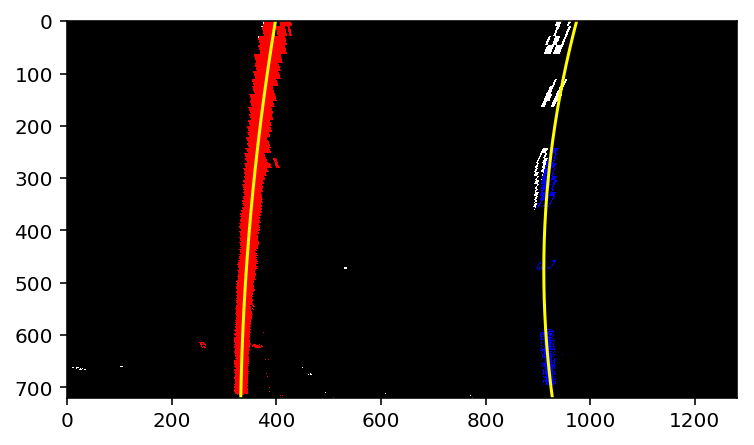

In [282]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
#     cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
#     cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(binary_warped)

# View your output
plt.imshow(result)

In [120]:
%run code/lane_pixel_finder

def measure_curvature_pixels():
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### Calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels()

print(left_curverad, right_curverad)

4939.961188205417 3085.399900450413


In [123]:
%run code/curvature_and_offset

# Calculate the radius of curvature and offset from the middle of in meters
left_curverad, offset = measure_curvature_and_offset_real(binary_warped)

print(left_curverad, 'm', offset, 'm')

1621.6758558391496 m -0.13742857142857143 m


In [10]:
%run code/lane_pixel_finder
%run code/fit_polynomial
%run code/curvature_and_offset

def mark_lane(binary_warped, img, undistorted):
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    left_fitx, right_fitx, ploty, _, _ = fit_polynomial(binary_warped.shape, leftx, lefty, rightx, righty)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    return result

result = mark_lane(binary_warped, img, undistorted)

# Calculate the radius of curvature and offset from the middle of in meters
left_curverad, offset = measure_curvature_and_offset_real(binary_warped)

if offset >= 0:
    direction = 'right'
else:
    direction = 'left'

font                   = cv2.FONT_HERSHEY_COMPLEX_SMALL
fontScale              = 2
fontColor              = (255,255,255)
lineType               = 2
radius_text = "Radius of curvature = %.0f(m)" % left_curverad
cv2.putText(result, radius_text, (100, 50), font, fontScale, fontColor, lineType)
offset_text = "Vehicle is %.2fm %s of center" % (np.absolute(offset), direction)
cv2.putText(result, offset_text, (100, 90), font, fontScale, fontColor, lineType)

plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

In [46]:
%run code/undistort
%run code/perspective_transform

def process_image_orig(img):
    undistorted = cal_undistort(img, objpoints, imgpoints)
    binary_img = threshed_binary_pipeline(undistorted, s_thresh=(100, 255), sx_thresh=(30, 100))
    img_size = (undistorted.shape[1], undistorted.shape[0])
    src = np.float32(
        [[(img_size[0] / 2) - 45, img_size[1] / 2 + 100],
        [((img_size[0] / 6)), img_size[1]],
        [(img_size[0] * 5 / 6) + 130, img_size[1]],
        [(img_size[0] / 2 + 95), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])

    binary_warped = warper(binary_img, src, dst)
    result = mark_lane(binary_warped, img, undistorted)
    return result

In [1]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
%run code/pipeline

In [ ]:
VideoFileClip("project_video.mp4").save_frame('my_image.jpg', t=29)
init_lines()
process_image(cv2.imread('my_image.jpg'))

VideoFileClip("project_video.mp4").save_frame('my_image.jpg', t=30)
process_image(cv2.imread('my_image.jpg'))

In [ ]:
output_video = 'project_video_output2.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(28,30)
init_lines()
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(output_video, audio=False)

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

In [ ]:
output_video = 'project_video_output.mp4'
# clip1 = VideoFileClip("project_video.mp4").subclip(0,2)
clip1 = VideoFileClip("project_video.mp4")
init_lines()
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(output_video, audio=False)

In [366]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))

In [ ]:
%run code/pipeline
import matplotlib.pyplot as plt

output_video = 'challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4").subclip(3,5)
init_lines()
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(output_video, audio=False)

# VideoFileClip("challenge_video.mp4").save_frame('my_image.jpg', t=0)
# image = cv2.imread('my_image.jpg')
# init_lines()
# output = process_image(image)

# left_line, right_line = get_lines()

# VideoFileClip("challenge_video.mp4").save_frame('my_image.jpg', t=30)
# process_image(cv2.imread('my_image.jpg'))

In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))